# Data Scraping Part

First, we will set up for running Selenium in Google Colab


In [119]:
# Set up for running selenium in Google Colab
## You don't need to run this code if you do it in Jupyter notebook, or other local Python setting
%%shell
sudo apt -y update
sudo apt install -y wget curl unzip
wget http://archive.ubuntu.com/ubuntu/pool/main/libu/libu2f-host/libu2f-udev_1.1.4-1_all.deb
dpkg -i libu2f-udev_1.1.4-1_all.deb
wget https://dl.google.com/linux/direct/google-chrome-stable_current_amd64.deb
dpkg -i google-chrome-stable_current_amd64.deb
CHROME_DRIVER_VERSION=`curl -sS chromedriver.storage.googleapis.com/LATEST_RELEASE`
wget -N https://chromedriver.storage.googleapis.com/$CHROME_DRIVER_VERSION/chromedriver_linux64.zip -P /tmp/
unzip -o /tmp/chromedriver_linux64.zip -d /tmp/
chmod +x /tmp/chromedriver
mv /tmp/chromedriver /usr/local/bin/chromedriver
pip install selenium

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:3 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:4 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Hit:6 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:7 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Fetched 229 kB in 1s (198 kB/s)
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
28 packages can be upgraded. Run 'apt list --upgradable' to see them.
Reading package lists... Done
Building dependenc

Install chromedriver-autoinstaller


In [120]:
!pip install chromedriver-autoinstaller

Set up Selenium WebDriver with Chromedriver Auto-installation

In [188]:
# Import necessary modules from Selenium
from selenium import webdriver
import chromedriver_autoinstaller

# Configure Chrome options
chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument('--headless')  # Ensure GUI is off
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--disable-dev-shm-usage')
chrome_options.add_argument('--disable-blink-features=AutomationControlled')
chrome_options.add_experimental_option('excludeSwitches', ['enable-logging'])

# Use chromedriver_autoinstaller to install the latest version of ChromeDriver
chromedriver_autoinstaller.install()

# Set up the WebDriver with configured options
driver = webdriver.Chrome(options=chrome_options)


Import Necessary Libraries


In [190]:
# Import necessary modules from Selenium
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

# Import BeautifulSoup for HTML parsing
from bs4 import BeautifulSoup

# Import time for adding delays
import time

# Import csv for handling CSV files
import csv


Scrape Main Page Function: Extracting Links from table

In [192]:
def scrape_main_page(main_url, driver):
    # Make an HTTP request to the main page
    base_url = 'https://global-standard.org'
    driver.get(main_url)

    # Click the search results button to load the data
    button = driver.find_element(By.XPATH, '//*[@id="xFormForm-0-submit"]')
    driver.execute_script("arguments[0].click();", button)
    time.sleep(5)  # Wait for the page to load

    # Click the pagination link to show more results
    pagination = driver.find_element(By.XPATH, '//a[@limit="50" and contains(@class, "xforms-limiter-limit")]')
    driver.execute_script("arguments[0].click();", pagination)
    time.sleep(5)  # Wait for the page to load

    # Wait for the table to load on the next page
    table = driver.find_element(By.XPATH, '//*[@id="tr-xFormAjaxTable-0"]/table')
    time.sleep(5)  # Wait for the table to load

    # Parse the HTML content with BeautifulSoup
    soup = BeautifulSoup(driver.page_source, 'html.parser')

    data = []  # List to store extracted links
    count = 0  # Counter to limit the number of iterations
    while count < 1000:
        # Corrected the attribute format in the find function
        table_body = table.find_element(By.TAG_NAME, 'tbody')
        rows = table_body.find_elements(By.TAG_NAME, 'tr')

        for row in rows:
            columns = row.find_elements(By.TAG_NAME, 'td')
            if len(columns) >= 5:  # Check if the fifth column exists
                link = columns[4].find_element(By.TAG_NAME, 'a').get_attribute('href')
                data.append(link)

            count += 1

        # Click the next page button
        next_button = driver.find_element(By.XPATH, '//a[@class="xforms-pager-next" and @aria-label="Next page"]')
        driver.execute_script("arguments[0].click();", next_button)
        time.sleep(5)  # Wait for the page to load

    return data

Scrape Company Details Function: Extracting Information from a Company Details Page


In [193]:
def scrape_company_details(company_url, driver):
    # Make an HTTP request to the company details page
    driver.get(company_url)
     # Add a delay to ensure the page is fully loaded
    time.sleep(2)
    # Base URL to create pdf links
    base_url = 'https://global-standard.org'
    # Parse the HTML content with BeautifulSoup
    soup = BeautifulSoup(driver.page_source, 'html.parser')

    # Extract details from the company page
    company_name = soup.select_one('#done h1')
    brand_name = soup.select_one('td#xFormTd-16 span.xforms-text')
    country = soup.select_one('td#xFormTd-0 span.xforms-text')
    product_category = soup.select_one('td#xFormTd-3 span.xforms-text')
    contact_name_spans = soup.select('td#xFormTd-4 span.xforms-text')
    contact_name = ' '.join([span.text.strip() for span in contact_name_spans])
    email_address = soup.select_one('td#xFormTd-7 span#xFormText-19 a[href]')
    ####details about adress
    adress = soup.select_one('#xFormTd-8 span.xforms-text')
    address_parts = ' '.join([span.text.strip() if span else '' for span in [adress]])
    adress2 = soup.select_one('#xFormTd-9 span.xforms-text')
    address_parts += ' ' + ' '.join([span.text.strip() if span else '' for span in [adress2]])
    Street = soup.select_one('#xFormTd-10 span.xforms-text')
    address_parts += ' ' + ' '.join([span.text.strip() if span else '' for span in [Street]])
    PostCode_City = soup.select('td#xFormTd-11 span.xforms-text')
    address_parts += ' ' + ' '.join([span.text.strip() if span else '' for span in PostCode_City])
    ####
    license_number = soup.select_one('td#xFormTd-15 span.xforms-text ')
    pdf_link = soup.select_one('td#xFormTd-19 a#xFormA-2[href]')
    certification_body = soup.select_one('td#xFormTd-18 span.xforms-text')
    expiry_date = soup.select_one('td#xFormTd-20 span.xforms-text')
    product_details = soup.select_one('td#xFormTd-17 span.xforms-text')

    return {
        'company': company_name.text if company_name else '',
        'brand_name': brand_name.text if brand_name else '',
        'country': country.text if country else '',
        'product_category': product_category.text if product_category else '',
        'contact_name': contact_name if contact_name else '',
        'email_address': email_address.text if email_address else '',
        'address_parts': address_parts if address_parts else '',
        'license_number': license_number.text if license_number else '',
        'pdf': base_url + pdf_link['href'] if pdf_link else '',
        'certification_body': certification_body.text if certification_body else '',
        'expiry_date': expiry_date.text if expiry_date else '',
        'product_details': product_details.text if product_details else ''
    }


Save Data to a CSV File


In [195]:
# Function to save data to a CSV file
def save_to_csv(data):
    # Define the CSV file name
    # file_name = 'scraped_data.csv'
    file_name = 'data.csv'

    # Get the keys (column names) from the data
    headers = data.keys()

    # Open the CSV file in append mode, create a new file if it doesn't exist
    with open(file_name, 'a', newline='', encoding='utf-8') as csvfile:
        # Create a CSV writer with specified fieldnames
        writer = csv.DictWriter(csvfile, fieldnames=headers)

        # Check if the file is empty; if yes, write the headers
        if csvfile.tell() == 0:
            writer.writeheader()

        # Write the data to the CSV file
        writer.writerow(data)

In [196]:
# Define the main URL for scraping
main_url = 'https://global-standard.org/find-suppliers-shops-and-inputs/certified-suppliers/database/search#howto'

# Scrape the main page to obtain a list of links
Data = scrape_main_page(main_url, driver)

# Loop through each link and scrape company details
for link in Data:
    # Scrape details for the current link
    scraped_data = scrape_company_details(link, driver)

    # Save the scraped data to a CSV file
    save_to_csv(scraped_data)

# Quit the WebDriver session after scraping is complete
driver.quit()

# Print a message indicating the successful completion of the data scraping process
print("Data scraping process completed successfully.")

Data scraping process completed successfully.


# Analysis Part

Read and Display Scraped Data

In [175]:
import pandas as pd

# Read the CSV file into a DataFrame
df = pd.read_csv('scrapedData.csv')
# Display the DataFrame
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   company             999 non-null    object
 1   brand_name          6 non-null      object
 2   country             999 non-null    object
 3   product_category    996 non-null    object
 4   contact_name        396 non-null    object
 5   email_address       444 non-null    object
 6   address_parts       1000 non-null   object
 7   license_number      999 non-null    object
 8   pdf                 196 non-null    object
 9   certification_body  999 non-null    object
 10  expiry_date         999 non-null    object
 11  product_details     906 non-null    object
dtypes: object(12)
memory usage: 93.9+ KB


Displaying the First Few Rows of the DataFrame




In [176]:
df.head()

,company,brand_name,country,product_category,contact_name,email_address,address_parts,license_number,pdf,certification_body,expiry_date,product_details
0,''P-AQRO'' MMC,NaN,Azerbaijan (AZ),Raw Fibres,Nazli Alancay,certification@docotton.com,SHIKHALIEV STREET 14 NARIMANOV,CU 1206162,https://global-standard.org/find-suppliers-sho...,Control Union Certifications,2024-03-17,Fibres
1,"""""MOHINI HEALTH & HYGIENE LIMITED""""",NaN,"India (IN), Madhya Pradesh","Hygiene products, Product category (other)",Sheheryar Dhatta,sheheryar@mohinifibers.com,PITHAMPUR 454774 Madhya Pradesh INDIA Plot No...,00279945,https://global-standard.org/find-suppliers-sho...,Ecocert Greenlife,2024-06-16,Personal care hygiene (PC0013)Undyed fibers (P...
2,"""BСT Cluster Agrokompleks"" LLC",NaN,Uzbekistan (UZ),Raw Fibres,Inoyat Nurov,bctagro@mail.ru,"43, Amir Timur Street 201000 Romitan city",CU 1240944,https://global-standard.org/find-suppliers-sho...,Control Union Certifications,2024-05-03,Fibres
3,"""TEOFILÓW"" S.A.",NaN,Poland (PL),Fabrics,NaN,office@teofilow.com.pl,"ul. Szparagowa 6/8 91-211, Łódź",1127384,NaN,Control Union Certifications,2024-01-16,Dyed fabrics (PC0025) Knitted fabrics (PD0058)...
4,“Istiqlol-2010” Ltd,NaN,Tajikistan (TJ),Raw Fibres,NaN,jamshed@farnico.com,"Polygon site, Khaeti Nav village council, Yava...",1213560,NaN,Control Union Certifications,2024-01-18,Undyed fibers (PC0034) Lint cotton (PD0074) 10...


## Data cleaning and preparation

Convert 'expiry_date' Column to Datetime Format

In [177]:
df['expiry_date'] = pd.to_datetime(df['expiry_date'])

Check Missing Values in DataFrame Columns

In [178]:
df.isna().sum()

company                 1
brand_name            994
country                 1
product_category        4
contact_name          604
email_address         556
address_parts           0
license_number          1
pdf                   804
certification_body      1
expiry_date             1
product_details        94
dtype: int64

Filter Rows with Missing Values in the 'company' Column


In [179]:
df[df['company'].isnull()]

,company,brand_name,country,product_category,contact_name,email_address,address_parts,license_number,pdf,certification_body,expiry_date,product_details
526,NaN,NaN,NaN,NaN,NaN,NaN,,NaN,NaN,NaN,NaT,NaN


Remove Rows with Missing Values in the 'company' Column


In [180]:
df.dropna(subset=['company'], inplace=True)

Check Missing Values After Removing Rows


In [181]:
df.isna().sum()

company                 0
brand_name            993
country                 0
product_category        3
contact_name          603
email_address         555
address_parts           0
license_number          0
pdf                   803
certification_body      0
expiry_date             0
product_details        93
dtype: int64

Clean 'company' and Format 'country' Columns

In [183]:
# Clean 'company' column: Remove specified special characters and leading/trailing whitespaces
df['company'] = df['company'].str.replace('["“”\'\']', '', regex=True).str.strip()
# Extract values before parentheses
before_parentheses = df['country'].str.extract(r'^([^(\s]+)')
# Extract values within parentheses
within_parentheses = df['country'].str.extract(r'\((.*?)\)')

# Combine both extracted values into a single column
df['country'] = before_parentheses + ' (' + within_parentheses + ')'

df.head()

,company,brand_name,country,product_category,contact_name,email_address,address_parts,license_number,pdf,certification_body,expiry_date,product_details
0,P-AQRO MMC,NaN,Azerbaijan (AZ),Raw Fibres,Nazli Alancay,certification@docotton.com,SHIKHALIEV STREET 14 NARIMANOV,CU 1206162,https://global-standard.org/find-suppliers-sho...,Control Union Certifications,2024-03-17,Fibres
1,MOHINI HEALTH & HYGIENE LIMITED,NaN,India (IN),"Hygiene products, Product category (other)",Sheheryar Dhatta,sheheryar@mohinifibers.com,PITHAMPUR 454774 Madhya Pradesh INDIA Plot No...,00279945,https://global-standard.org/find-suppliers-sho...,Ecocert Greenlife,2024-06-16,Personal care hygiene (PC0013)Undyed fibers (P...
2,BСT Cluster Agrokompleks LLC,NaN,Uzbekistan (UZ),Raw Fibres,Inoyat Nurov,bctagro@mail.ru,"43, Amir Timur Street 201000 Romitan city",CU 1240944,https://global-standard.org/find-suppliers-sho...,Control Union Certifications,2024-05-03,Fibres
3,TEOFILÓW S.A.,NaN,Poland (PL),Fabrics,NaN,office@teofilow.com.pl,"ul. Szparagowa 6/8 91-211, Łódź",1127384,NaN,Control Union Certifications,2024-01-16,Dyed fabrics (PC0025) Knitted fabrics (PD0058)...
4,Istiqlol-2010 Ltd,NaN,Tajikistan (TJ),Raw Fibres,NaN,jamshed@farnico.com,"Polygon site, Khaeti Nav village council, Yava...",1213560,NaN,Control Union Certifications,2024-01-18,Undyed fibers (PC0034) Lint cotton (PD0074) 10...


## Analusing of the Database




### Which countries have the most certified companies?

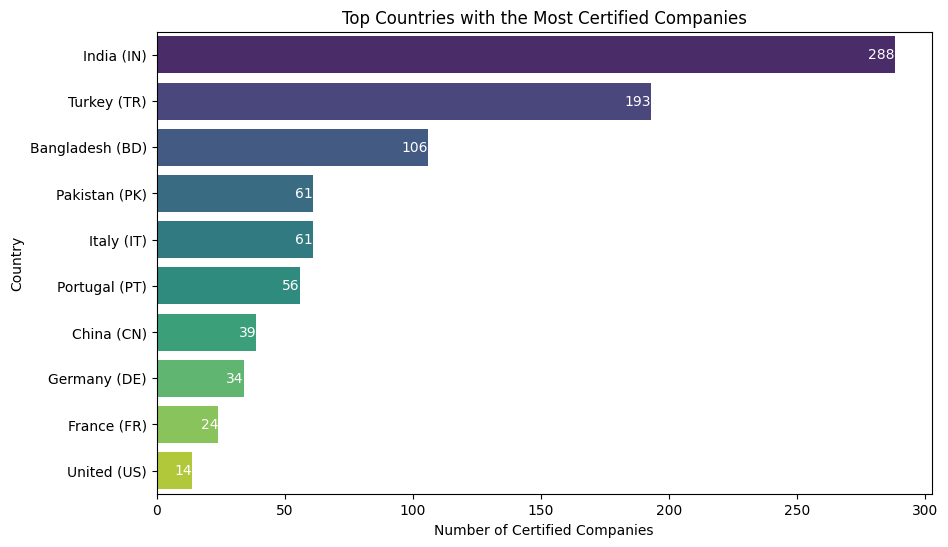

In [184]:
import matplotlib.pyplot as plt
import seaborn as sns

# Count certified companies by country
certified_companies_per_country = df.groupby('country')['company'].count().sort_values(ascending=False).head(10)

# Create a bar plot for top countries with the most certified companies
plt.figure(figsize=(10, 6))
plot = sns.barplot(x=certified_companies_per_country.values, y=certified_companies_per_country.index, palette='viridis')
plt.xlabel('Number of Certified Companies')
plt.ylabel('Country')
plt.title('Top Countries with the Most Certified Companies')

# Add text annotations inside each bar with count values
for index, value in enumerate(certified_companies_per_country.values):
    plot.text(value, index, str(value), ha='right', va='center', color='white', fontsize=10)

plt.show()


### What are the most certified product categories?

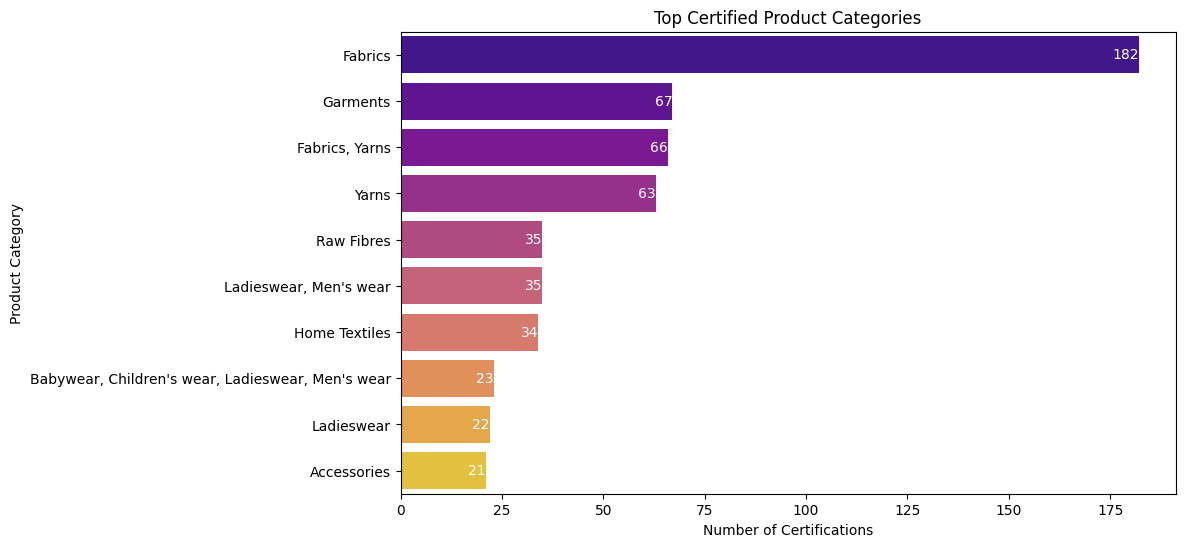

In [185]:
# Count occurrences of product categories
certified_product_categories = df['product_category'].value_counts().head(10)

# Create a horizontal bar plot for top certified product categories
plt.figure(figsize=(10, 6))
plot = sns.barplot(x=certified_product_categories.values, y=certified_product_categories.index, palette='plasma')
plt.xlabel('Number of Certifications')
plt.ylabel('Product Category')
plt.title('Top Certified Product Categories')

# Add text annotations inside each bar with count values
for index, value in enumerate(certified_product_categories.values):
    plot.text(value, index, str(value), ha='right', va='center', color='white', fontsize=10)

plt.show()


### Identify the most common Certification Body.


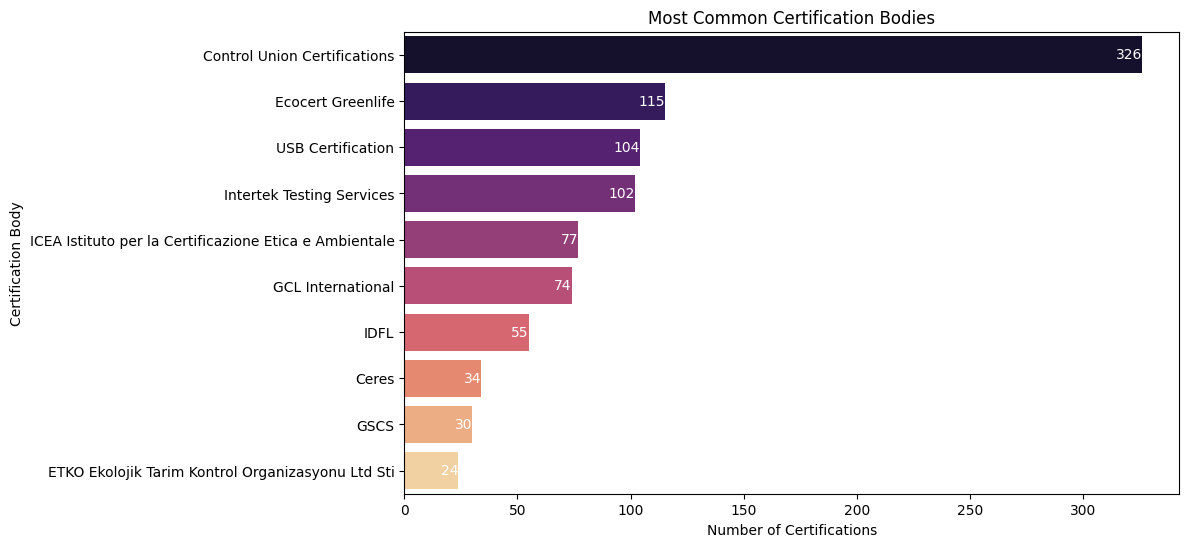

In [187]:
# Count occurrences of Certification Bodies
certification_body_counts = df['certification_body'].value_counts().head(10)

# Create a horizontal bar plot for top Certification Bodies
plt.figure(figsize=(10, 6))
plot = sns.barplot(x=certification_body_counts.values, y=certification_body_counts.index, palette='magma')
plt.xlabel('Number of Certifications')
plt.ylabel('Certification Body')
plt.title('Most Common Certification Bodies')

# Add text annotations inside each bar with count values
for index, value in enumerate(certification_body_counts.values):
    plot.text(value, index, str(value), ha='right', va='center', color='white', fontsize=10)

plt.show()
